In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import numpy as np

In [3]:
from IPython.core.debugger import set_trace

In [4]:
from skimage.measure import label, regionprops
from scipy.signal import find_peaks

In [5]:
plt.rcParams['figure.figsize'] = [12,10]

In [6]:
p = (Path('../190819'))

In [7]:
[x for x in p.iterdir()]

[PosixPath('../190819/Nucleophosmin'),
 PosixPath('../190819/masks'),
 PosixPath('../190819/nuclei_masks'),
 PosixPath('../190819/DAPI'),
 PosixPath('../190819/Trans')]

In [8]:
dap = p/'DAPI'
nuc = p/'Nucleophosmin'
tra = p/'Trans'

In [9]:
sorted(list(nuc.iterdir()))[0]

PosixPath('../190819/Nucleophosmin/20190625 Cas9-17 60x confocal TL_B02_s1_w2.TIF')

In [10]:
nuc_img = plt.imread(sorted(list(nuc.iterdir()))[38])
dap_img = plt.imread(sorted(list(dap.iterdir()))[38])

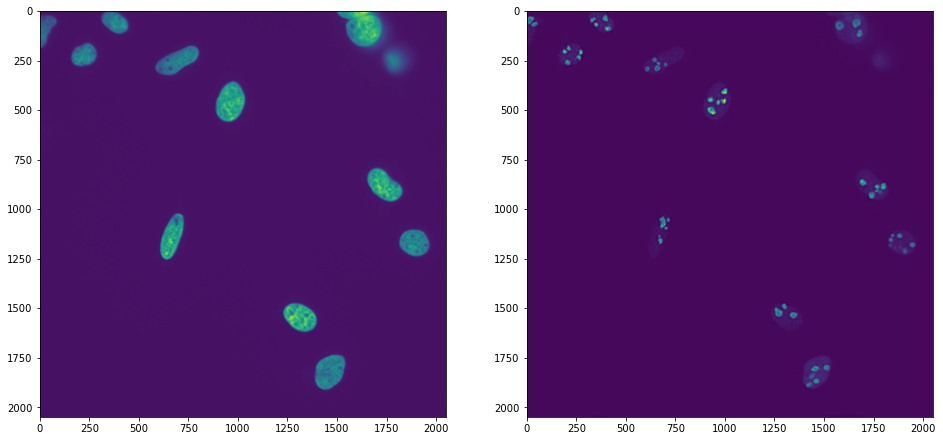

In [11]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,12))
ax1.imshow(dap_img)
ax2.imshow(nuc_img)

In [12]:
lab_nuc = label((nuc_img>(nuc_img.mean()*1.5))).astype(np.uint8) # *1.5 because it sets the threshold a bit higher to get rid of bg
rp = regionprops(lab_nuc, nuc_img)

In [13]:
rp[10]

In [14]:
nucleus = rp[10].intensity_image

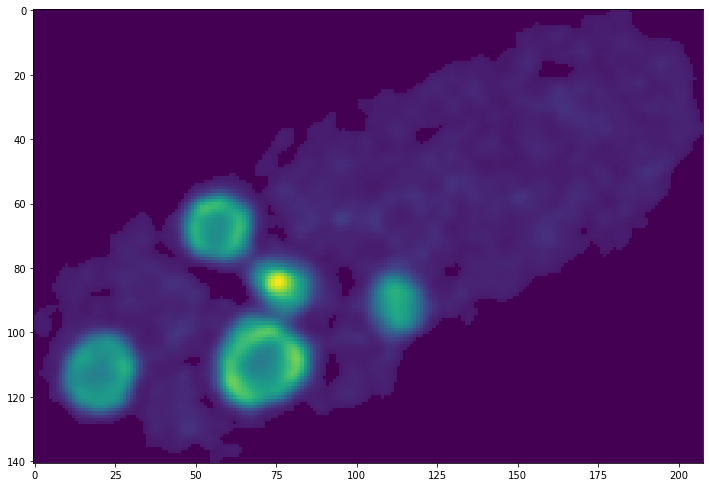

In [15]:
plt.imshow(nucleus)

In [16]:
nucleus = np.ma.masked_equal(nucleus,0).compressed()

In [17]:
samp = np.random.choice(nucleus.ravel(),50)

In [18]:
samp

array([ 3204,  2400,  3188,  2274,  2798,  2676,  2210,  1879,  2626,
        1892,  2173,  2085,  2200,  2575,  2691,  2097,  7467,  3594,
        3183,  2224,  3320, 11934, 17164,  2298,  2170,  5124,  2518,
       18756,  7171,  8546,  2404,  2380,  2019, 10240,  3642,  3094,
        3607,  2913,  1984,  2536,  3145,  3076,  2623,  2446,  8105,
        2822,  1878, 13375,  2702,  4146], dtype=uint16)

In [19]:
t = samp.mean()/2
for i in range(5):
    m1 = samp[samp<=t]
    m2 = samp[samp>t]
    print('thresh:', t, 'm1:', m1.mean(), 'm2:', m2.mean())
    t= (m1.mean()+m2.mean())/2

thresh: 2135.74 m1: 1976.2857142857142 m2: 4645.116279069767
thresh: 3310.7009966777405 m1: 2496.657142857143 m2: 8412.733333333334
thresh: 5454.695238095238 m1: 2702.829268292683 m2: 11417.555555555555
thresh: 7060.192411924119 m1: 2702.829268292683 m2: 11417.555555555555
thresh: 7060.192411924119 m1: 2702.829268292683 m2: 11417.555555555555


### Create mask tif files:
* iterate through folder to load images
* segment into nuclei with skimage measure label
* create regionprops
* segment nuclei into nucleoli
* restore 2048x2048 array from nucleoli coordinates 

In [20]:
def segment_nucleoli(arr):
    mask = np.zeros(arr.shape)
    lab_nuc = label((arr>(arr.mean()*1.5))).astype(np.uint8) # *1.5 because it sets the threshold a bit higher to get rid of bg
    rp = regionprops(lab_nuc, arr)
    for reg in rp:   
        if reg.area > 2000: # minimum nucleus size  
            nucleus = np.ma.masked_equal(reg.intensity_image,0).compressed() #get rid of all black pixels and flatten
            samp = np.random.choice(nucleus.ravel(), 300)
            thresh = samp.mean()/2
            for i in range(10):                
                m1 = samp[samp<=thresh]
                m2 = samp[samp>thresh]
#                 print(i, 'thresh:',thresh, 'm1:', len(m1), 'm2:', len(m2))
                if len(m1)>0: # sometimes the m1 segment is empty
                    thresh = (m1.mean()+m2.mean())/2  
                else:
                    thresh = m2.mean()/1.5 # so we set the threshold a bit higher and try again
            lab_nuo = label(reg.intensity_image>thresh*1.2)  # makes the threshold a bit stricter       
            rp_nuo = regionprops(lab_nuo)        
            for reg_nuo in rp_nuo:
                if reg_nuo.area<reg.area/2: # a nucleolus that's bigger than half a nucleus is probably not correct
                    bbox_offset = np.expand_dims(reg.bbox[:2],-1)
                    coords = np.argwhere(reg_nuo.filled_image).T
                    nuo_coords = np.expand_dims(reg_nuo.bbox[:2],-1)+coords+bbox_offset # place the filled nulceoli
                    #nuo_coords = reg_nuo.coords.T+bbox_offset
                    mask[tuple([*nuo_coords])]=1
    return mask.astype(np.uint8) # this allows to save images as png with values [0,1]

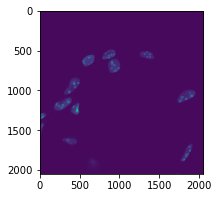

In [21]:
nuc_img = plt.imread(Path('../190819/Nucleophosmin/20190625 Cas9-17 60x confocal TL_D02_s2_w2.TIF'))
plt.figure(figsize=(4,3))
plt.imshow(nuc_img)

In [22]:
mask = segment_nucleoli(nuc_img)

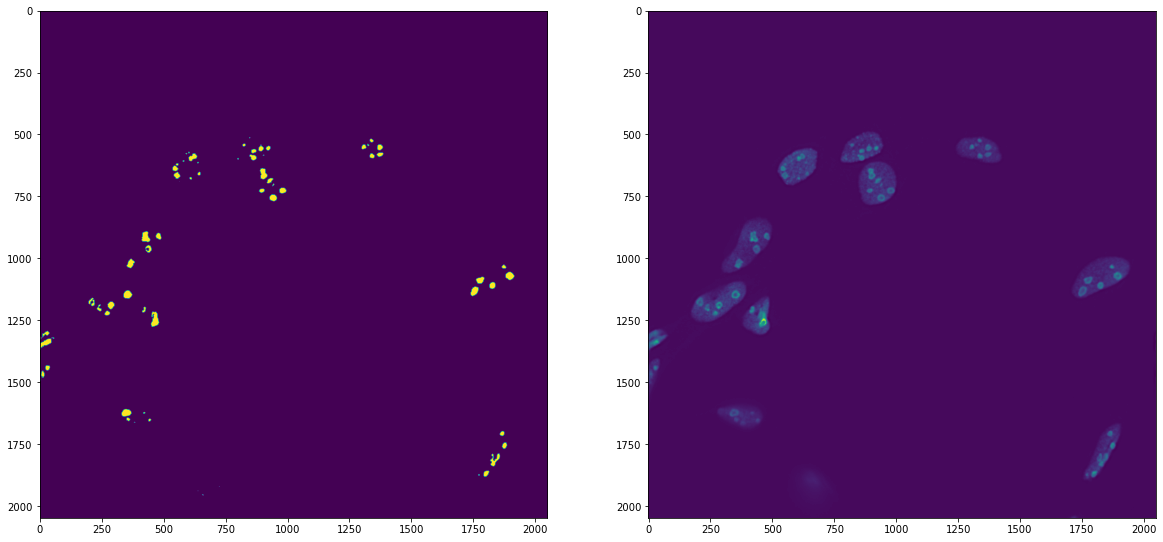

In [23]:
fig, ax = plt.subplots(1,2, figsize=(20,16))
ax1, ax2 = ax.ravel()
ax1.imshow(mask)
ax2.imshow(nuc_img)

In [24]:
import napari

In [26]:
%gui qt

In [34]:
viewer = napari.view_image(nuc_img, rgb=False, name = 'nucleoli', colormap = 'green')
viewer.add_image(mask, colormap = 'red', contrast_limits = [0,1])

<Labels layer 'mask' at 0x7f3d84a54ee0>

https://napari.org/tutorials/applications/annotate_segmentation

In [112]:
print(mask.min(), mask.max())

0 1


In [86]:
save_p = p/'masks'

In [104]:
import imageio

In [164]:
for f in nuc.iterdir():
    print(save_p/f.parts[-1])
    img = plt.imread(f)
    mask = segment_nucleoli(img)
#     np.save(save_p/f.parts[-1][:-4], mask)
    imageio.imwrite(save_p/f.parts[-1][:-4], mask, format = 'png')

../190819/masks/20190625 Cas9-17 60x confocal TL_G03_s3_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_E09_s1_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_D11_s6_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_E05_s5_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_F10_s4_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_D10_s3_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_F05_s6_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_G10_s4_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_E08_s9_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_E11_s6_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_B10_s4_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_E03_s3_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_D11_s4_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_F10_s9_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_D05_s5_w2.TIF
../190819/masks/20190625 Cas9-17 60x confocal TL_D05_s1

In [114]:
mask.dtype

dtype('uint8')

In [122]:
list(save_p.iterdir())[1]

PosixPath('../190819/masks/20190625 Cas9-17 60x confocal TL_D02_s2_w2')

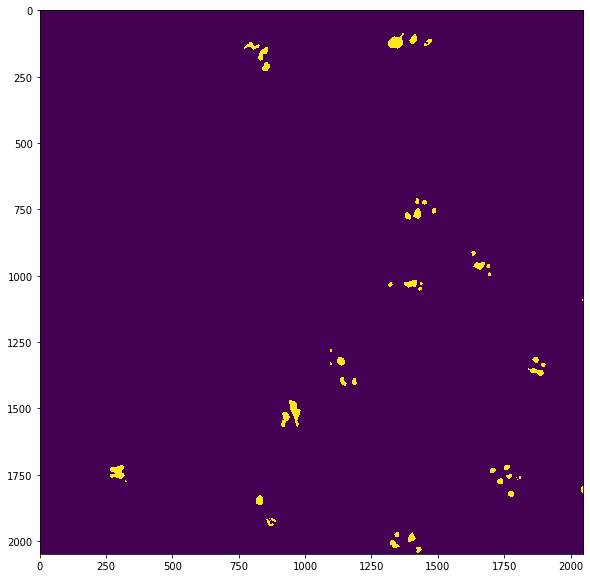

In [166]:
mimg = plt.imread(list(save_p.iterdir())[2])
plt.imshow(mimg)

In [116]:
mimg.min()

0

In [117]:
mimg.max()

1